# Executive Summary

This study used multiple linear regression to predict covid rates in Toronto's 140 neighborhoods using demographic data from Stats Canada. The correlation of these features to the target variable were analyzed in order to limit the number of potential predictors. Features which were highly correlated to each other were removed and an analysis of the p-values were done recursively to eliminate further predictors. Using the IQR method a few neighborhoods were removed that were considered outliers. The final model used only three variables to predict covid rates in the neighborhoods with an $R^2$  value of 0.605. Specifically these variables in the Stats Canada demographic database are know as Black (Visible Minority), Occupations in manufacturing and utilities, and Journey to work Between 12 p.m. and 4:59 a.m. The model was found to be _Rate = 1038 + 157.7 \* Black\% + 140.8 \* ManufactJob + 170.1 \* WorkNights_. Such a model could be useful in order to determine where to target prescriptive or preemptive action. 

# Introduction

The purpose of this study is to build a linear regression model that will predict the number of covid-19 cases for any Toronto neighborhood based on its demographic data. Predicting covid-19 cases is useful in that an understanding of which socioeconomic factors that influence the growth of disease in a community will help with our understanding of the virus. This knowledge will enable resources to be better targeted in the future to help prevent transmission during this, or any future pandemic.

## Load Libraries

The relevant data science libraries are loaded into the Jupyter notebook.

In [709]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
%matplotlib inline
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

## Data

A population Census is held across Canada every 5 years. It collects data about age and sex, families and households, language, immigration and internal migration, racial diversity, Aboriginal peoples, housing, education, income, and labor. 
The City of Toronto Neighborhood Profiles use this Census data to provide a portrait of the demographic, social and economic characteristics of the people and households in each City of Toronto neighborhood.$^{[1]}$

The data is made available through Toronto's Open Data portal (https://open.toronto.ca/).$^{[2]}$

Two datasets from this site were used for this study. One that shows the number of covid cases by Toronto neighborhood (https://open.toronto.ca/dataset/covid-19-cases-in-toronto/) and the other contains demographic features of each of these neighborhoods (https://open.toronto.ca/dataset/neighbourhood-profiles/). There are over 2,300 features shown for each neighborhood including:

### Load Files

Pandas read_csv function is used to load the two files into dataframes.

In [710]:
covid_to = pd.read_csv('data/CityofToronto_COVID-19_NeighbourhoodData.csv')

In [711]:
neigh = pd.read_csv("data/neighbourhood-profiles-2016-csv_ADJ.csv")

### Data Cleaning

The demographic data is a huge dataset containing over 2300 rows, each one representing a different demographic feature. In order to create one usable dataset the following tasks were performed:

1. The dataset was transposed so that the columns, which are the Toronto neighborhoods become rows and each feature becomes a column.
2. The columns which are presented as absolute numbers, for example *Number of Latin Americans*, were changed to represent percentages of each number compared to the neighborhood population.
3. Every column is given a unique identifying name.
4. A dataframe was created to capture the column descriptions which are quite lengthy.
5. Null rows were dropped - these were summary rows which did not relate to each neighborhood.
6. All the numeric columns were converted to floats - there were no categorical columns.
7. The two dataframes (demographic data and covid case data) were merged on the neighborhood id column to create one dataframe.

In [712]:
# The Neighbourhood file has Neighbourhoods as columns so we must 
# transpose it.
neighTO = neigh.transpose()

Now that the data is transposed there are over 2300 columns. Let's keep track of the meanings of these columns so we can 
later use this information to interpret the results. In the meantime we will refer to the columns by
their numeric names. A sample from this table is shown below.

In [713]:
# Let's the column names to strings
neighTO.columns = ["Col_" + str(x) for x in neighTO.columns]

In [714]:
colNames = neighTO.iloc[0:5,:].transpose()

In [715]:
%%script false --no-raise-error
# Now we have a dataframe of all the column names
print(colNames.head(5).iloc[:,0:5].to_latex(index=False))  

In [716]:
# Let's remove all the descriptive rows
neighTO = neighTO.iloc[5:,:]

In [717]:
# We can remove the city of Toronto
neighTO = neighTO[neighTO.index != 'City of Toronto']

In [718]:
# Let's ensure the neighborhoodID in both files is an int so we can
# join the files
neighTO['Col_0'] = neighTO['Col_0'].astype(int)

In [719]:
# We drop the null row and convert ID to int
covid_to.dropna(inplace=True)
covid_to['Neighbourhood ID'] = covid_to['Neighbourhood ID'].astype(int)

In [720]:
# Let's convert the demographic data to floats - select only string columns
for x in neighTO.select_dtypes(include='object').columns:
    if x != 'Col_0':
        # Remove % symbol if present
        neighTO[x] = neighTO[x].replace({'%':''}, regex = True)
        neighTO[x] = neighTO[x].astype(float)

In [721]:
# We see they are all floats except for the int column
#neighTO.info();

In [722]:
# Now we can see that all our columns are numeric
#neighTO.describe().iloc[:,1:5]
#print(neighTO.describe().iloc[:,1:5].to_latex(index=False)) 

We can confirm that all the data has been converted to floats. We need to join the datasets so we have one dataset with all the features and target.

In [723]:
# Rename the column so they match in both files
neighTO.rename(columns={'Col_0': "Neighbourhood ID"}, inplace=True)

In [724]:
# Join the files on Neighbourhood ID
NeighCases = pd.merge(neighTO, covid_to, how='left', on=['Neighbourhood ID'])

In [725]:
# Let's write this to excel to back it up.
NeighCases.to_csv("data/NeigCases.csv")

## Data Exploration

There's a huge difference in the rate of covid-19 cases in each Toronto neighborhood. 

The top 5 neighborhoods have **dramatically higher case rates** than the bottom five neighborhoods.

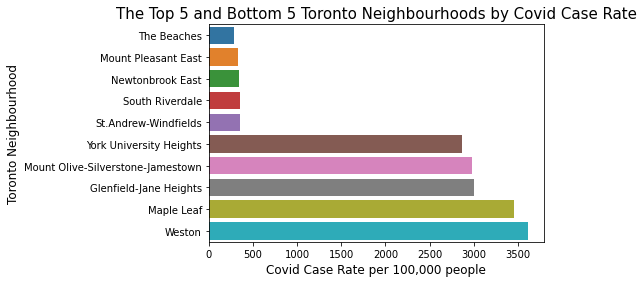

In [810]:
sns.reset_orig()
df = NeighCases[['Neighbourhood Name', "Rate per 100,000 people"]].sort_values("Rate per 100,000 people")
df.columns = ['Neighbourhood', 'Rate per 100,000 people']

ax = sns.barplot(data=df.head(5).append(df.tail(5)), y='Neighbourhood',x='Rate per 100,000 people',orient='h')
# txt="Figure 1. The top 5 and bottom 5 Toronto neighborhoods by covid case rate."
# # plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=14)
# plt.figtext(0.5, -0.1, txt, wrap=True, horizontalalignment='center', fontsize=13)

plt.title('The Top 5 and Bottom 5 Toronto Neighbourhoods by Covid Case Rate',fontsize= 15)
plt.xlabel("Covid Case Rate per 100,000 people", fontsize=12)
plt.ylabel("Toronto Neighbourhood", fontsize=12);

The rate in the neighborhood of Weston has a covid case rate of almost 13 times that of the Beaches neighborhood.

In [749]:
#df.head(1).append(df.tail(1))
#print(df.head(1).append(df.tail(1)).to_latex(index=False)) 

Various media reports have shown that certain demographic factors can influence covid rates$^{[3]}$. Reports have shown that the virus has disproportionately affected communities based on the following factors:


* Racial Profile<br>
* Density<br>
* Employment<br>
* Income<br>

In [728]:
#colNames.Category.unique()

Let's examine some columns that correspond to these factors and see how they relate to covid rates. 

The following graph shows how covid rates vary depending on the proportion of different racial groups in each Toronto neighborhood. 
There seems to be a moderate positive relationship between covid rates and the percent of Blacks in each neighborhood and also Latin Americans.

In [729]:
colNames[colNames['Category'] == 'Visible minority'].index;

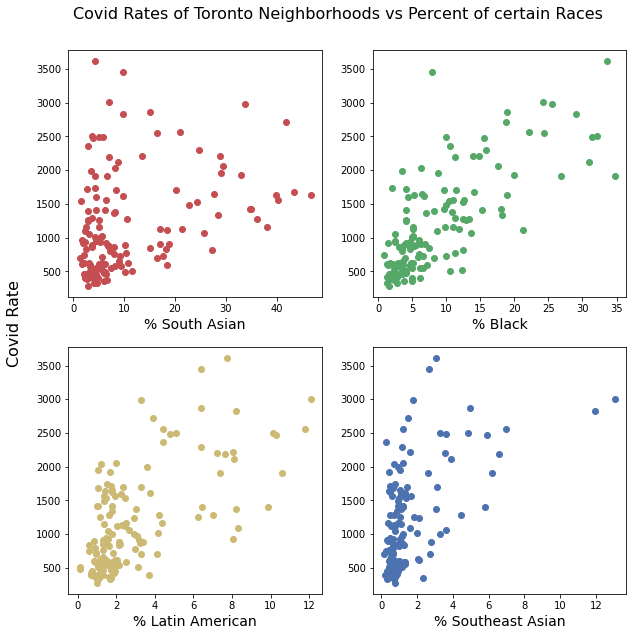

In [805]:
df = NeighCases[colNames[colNames['Category'] == 'Visible minority'].index]
df = df.rename(columns={"Col_1266": "Visible Minoriaty", "Col_1267": "South Asian",
                  "Col_1077": "Latin American", "Col_1269": "Black", "Col_1272": "Southeast Asian"})
df['Rate'] = NeighCases['Rate per 100,000 people']
df = df[["South Asian", "Latin American", "Black", "Southeast Asian","Rate"]]

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(10,10))

ax[0,0].scatter(data=df, x='South Asian', y='Rate', c="r")
ax[0,0].set_xlabel("% South Asian", fontsize=14)
ax[0,1].scatter(data=df, x='Black', y='Rate', c="g")
ax[0,1].set_xlabel("% Black", fontsize=14)
ax[1,0].scatter(data=df, x='Latin American', y='Rate', c="y")
ax[1,0].set_xlabel("% Latin American", fontsize=14)
ax[1,1].scatter(data=df, x='Southeast Asian', y='Rate', c='b')
ax[1,1].set_xlabel("% Southeast Asian", fontsize=14);
fig.text(0.04, 0.5, 'Covid Rate', va='center', rotation='vertical', fontsize=16)
fig.suptitle('Covid Rates of Toronto Neighborhoods vs Percent of certain Races', fontsize=16, y=.94);


Now lets check some other potential predictors, including income, density and employment.

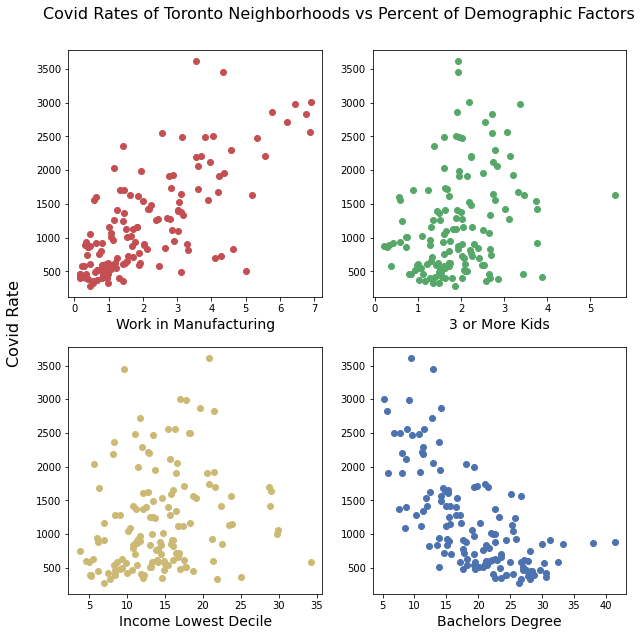

In [808]:
df = NeighCases[["Col_1855", "Col_100", "Col_1047", "Col_1635"]]
df = df.rename(columns={"Col_1855": "Work in Manufacturing", "Col_100": "3 or More Kids",\
                        "Col_1047": "Income Lowest Decile", "Col_1635": "Bachelors Degree"})
df['Rate'] = NeighCases['Rate per 100,000 people']
# Create the pairplot

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(10,10))

ax[0,0].scatter(data=df, x='Work in Manufacturing', y='Rate', c="r")
ax[0,0].set_xlabel("Work in Manufacturing", fontsize=14)
ax[0,1].scatter(data=df, x='3 or More Kids', y='Rate', c="g")
ax[0,1].set_xlabel("3 or More Kids", fontsize=14)
ax[1,0].scatter(data=df, x='Income Lowest Decile', y='Rate', c="y")
ax[1,0].set_xlabel("Income Lowest Decile", fontsize=14)
ax[1,1].scatter(data=df, x='Bachelors Degree', y='Rate', c='b')
ax[1,1].set_xlabel("Bachelors Degree", fontsize=14);
fig.text(0.04, 0.5, 'Covid Rate', va='center', rotation='vertical', fontsize=16)
fig.suptitle('Covid Rates of Toronto Neighborhoods vs Percent of Demographic Factors', fontsize=16, y=.94);

There seems to be a positive trend between the proportion of the population that work in manufacturing jobs in a neighborhood vs. covid rates, and a negative trend between the proportion who have Bachelor's Degrees.

## Feature Selection

There are so many features (over 2,300) so in order to narrow it down we will examine the correlation of every feature to the target (Covid rate per 100,000 people). One of the most common ways to identify potential features is to examine the correlation between columns of X and y (Corr)$^{[4]}$. 

We will select the top 10 features based on this correlation and use this as our new pared down dataset.

In [695]:
# Let's look at all the features and how they compare to 
# the target - this will show the top 100 features
cor = NeighCases.corr()
threshold = 0.6
a=abs(cor['Rate per 100,000 people'])
result=pd.DataFrame(a[a>0.6])
feat_cor = result.sort_values('Rate per 100,000 people', ascending=False).head(100)

In [696]:
# Let's remove the Case Count column and examine these variables
feat_cor.drop('Case Count', inplace=True)
# feat_cor.drop('Rate per 100,000 people', inplace=True)

In [824]:
try:
    feat_cor.reset_index(level=0, inplace=True)
except:
    None

In [825]:
try:
    colNames.reset_index(level=0, inplace=True)
except:
    None

In [699]:
dfCol = colNames[['index','Category', 'Characteristic']]

In [700]:
feat_corName = pd.merge(feat_cor, dfCol, how='left', on=['index'])

The top 10 features in order of descending correlation to "Rate per 100,000" column. The top features are all seemingly related to Black, Caribbean and African origins except for a Labor related column which is Occupations in manufacturing and utilities.

In [701]:
# Here are the top 10 features in order of desending correlation to "Rate per 100,000"
df_fcN = feat_corName.sort_values(by='Rate per 100,000 people', ascending=False).head(10)
#print(df_fcN.to_latex(index=False)) 

Let's look at the top correlation in each Category of predictors. The category with the top correlated predictor is "Visible Minority" (**0.75**) and "Housing" is the category with the lowest correlated predictor (**0.63**).

In [733]:
# Return top from each category
#groupMax = feat_corName.groupby(["Category"])
#groupMax.max('Rate per 100,000 people')
#print(groupMax.max('Rate per 100,000 people').to_latex(index=False)) 

It seems logical that predictors within the same category would be correlated, so let's find the top correlated predictor within each category.

In [734]:
# *****
# Let's find the rows with the highest value for each category
idx = feat_corName.groupby(['Category'])['Rate per 100,000 people'].transform(max) == \
feat_corName['Rate per 100,000 people']
#feat_corName[idx]
#print(feat_corName[idx].to_latex(index=False)) 

In [617]:
# Let's create a dataframe using only these values and let's make the
# columns more readable.
NeighCovid = NeighCases[feat_corName[idx]['index']]
NeighCovid['Rate'] = NeighCases['Rate per 100,000 people']

In [618]:
NeighCovid.columns = ['Black%', 'Jamaica%', 'Jamaican', 'CongoLang', 'ManufactJob', 'MoreThan2Kids',\
                      'ThirdDecIncome', 'BachelorDegree', 'WorkNights', 'BothMaintHouse', 'Rate']

### Statistics and Distributions

Let's examine the main statistics, such as mean and median, of our dataset. We can see these stats using the describe() function.

In [1021]:
#NeighCovid.describe()

The statistics don't look out of the usual. We can see that the percent of Black people in each neighborhood vary from less than 1% to almost 35%. The mean number of people with Bachelor's degrees is 19% and one neighborhood has more than 41% of it's residents having the degree.

No values appear especially unusual and nothing appears completely out of the ordinary here.

In [1028]:
#print(NeighCovid.describe().to_latex(index=True)) 


Let's look at the distributions of our predictors. We can see from the graph below that they are all fairly normally distributed and unimodal. The *Black %* feature is more skewed to the right than the other features. It's good that they are normally distributed as this is a prerequisite for building a linear regression model.

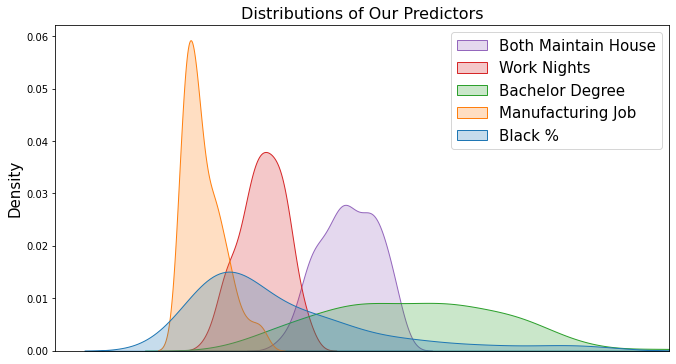

In [1025]:
# Create a distribution plot showing each predictor
# First create a new dataframe with col names as values using melt to make 
# visualizing it easier
dfDistPlot = NeighCovid.melt(value_vars=['Black%', 'ManufactJob', 'BachelorDegree', 'WorkNights',
       'BothMaintHouse'], ignore_index=True)
dfDistPlot.reset_index()

plt.figure(figsize=(11,6))
sns.kdeplot(data=dfDistPlot,shade=True,  x="value", hue="variable")
plt.title("Distributions of Our Predictors", fontsize=16)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.ylabel("Density", fontsize=15)
plt.xlabel("")
plt.xlim(-10,40)
plt.legend(["Both Maintain House","Work Nights" ,"Bachelor Degree","Manufacturing Job","Black %"],
          prop={"size":15});

### Remove Correlated Predictors

If certain features are highly correlated with other ones then there are redundant features and they can be removed to make the model more simple. The following heatmap shows that there are several highly correlated features, for example _Black_ with *Jamaica%*, *Jamaican*, *CongoLang* and *MoreThan2Kids*.

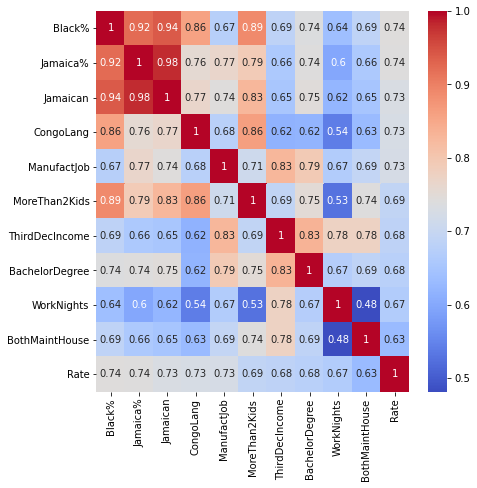

In [619]:
# Correlation of variables
plt.figure(figsize=(7,7))
sns.heatmap(abs(NeighCovid.corr()), annot=True, cmap="coolwarm");

It makes sense than language, ethnic origin, language and visible minority categories of data
are highly correlated. Let's remove the *Jamaica%*, *Jamaican*, and *CongoLang* predictors.

In [620]:
# Remove columns from dataset
NeighCovid.drop(['Jamaica%', 'Jamaican', 'CongoLang'], axis=1, inplace=True)

In the interest of simplicity we can reduce features further. Black and Morethan2Kids is highly correlated, as well as ManufactJob and ThirdDecIncome so we will reduce the features that are least correlated with Rate.

In [622]:
NeighCovid.drop(['MoreThan2Kids', 'ThirdDecIncome'], axis=1, inplace=True)

Let's look at the heatmap of feature correlations. We can now see that we have all the correlations under **0.80**. Let's use these remaining features to build a model.

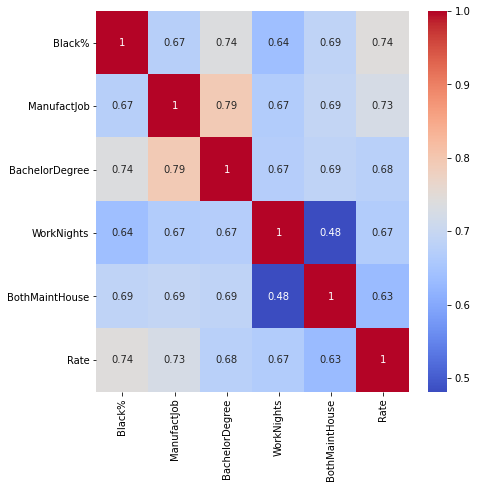

In [623]:
plt.figure(figsize=(7,7))
sns.heatmap(abs(NeighCovid.corr()), annot=True, cmap="coolwarm");

# Method & Results

## Linear Regression

Linear regression is a linear way of modeling the relationship between a dependent variable (target) and 
one or more independent variables (features). If there is one feature it is called simple linear regression, and
if there is more than one it is called multiple linear regression.$^{[5]}$

The equation for multiple linear regression is as follows:

$y_i = \beta_0 + \beta _1 x_{i1} + \beta _2 x_{i2} + ... + \beta _p x_{ip} + \epsilon$

where, for i=n observations:

$y_i$ = dependent variable

$x_i$ = expanatory variables

$\beta_0$ = y-intercept (constant term)

$\beta_p$ = slope coefficients for each explanatory variable

$\epsilon$ = the model's error term (also known as the residuals)

In [624]:
# Run the functions notebook
%run CovidFunctions.ipynb

### Simple Linear Regression

Let's start with a simple linear regression model. We will use only one feature to predict the one target (Covid Rate). We will use the column which is most highly correlated to Covid Rate which is the percent of Black people in each neighborhood.

In [625]:
# Create the X and y datasets
dfB = NeighCovid[['Black%','Rate']]
X = NeighCovid[["Black%"]]
y = NeighCovid["Rate"]

In [626]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [627]:
# Split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 11)

In [628]:
# Create and train the model
from sklearn.linear_model import LinearRegression
#Create the model :
regressor = LinearRegression()
#Train the model :
regressor.fit(X_train, y_train)

LinearRegression()

Here's the coefficient of the model:

In [812]:
L = regressor.coef_
L[0]

535.7894650023125

Here is the intercept:

In [813]:
regressor.intercept_

1217.1073039109747

This is the equation of our current model:

In [814]:
print("Rate = {:.2f} + {:.2f}*Black% ".format(regressor.intercept_,L[0]))

Rate = 1217.11 + 535.79*Black% 


In [815]:
y_pred = regressor.predict(X_test)

Let's compare the actual vs. predicted values. They don't appear to be that close.

In [634]:
df_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
#df_results.head(10)
#print(df_results.head(10).to_latex(index=False)) 

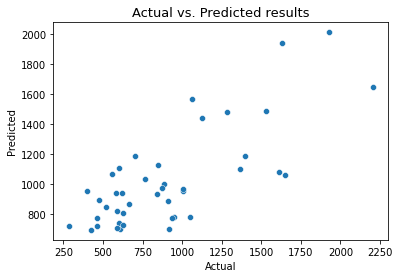

In [738]:
# Let's examine a scatterplot of the actual vs. predicted values
sns.scatterplot(data=df_results, x = 'Actual', y = 'Predicted')
plt.title("Actual vs. Predicted results", fontsize=13);

Let's look at the results of the model. The **$R^2$ value is 0.49**. This is quite good for a social study such as this one. 

In [636]:
print(f"The R-squared value is: \
      {ReturnR2value(dfB,'R2')} \nThe Root MSE is:\t\
      {ReturnR2value(dfB,'MSE')} \nThe Intercept is:\t\
      {ReturnR2value(dfB,'Intercept')}")     

The R-squared value is:       49.09 
The Root MSE is:	      313.20868156422546 
The Intercept is:	      1217.1073039109747


### Outliers

In order to improve the model we could use more training data, however as we only have 140 neighborhoods we do not have that much data to begin with. We can also look at outliers.

The following boxplots show the outliers for the X (%Black) and y (Rate) columns.

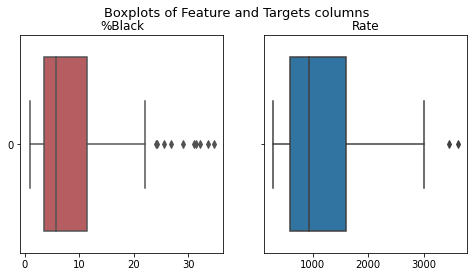

In [637]:
# Show boxplots for predictor and target
df = NeighCovid[["Black%"]]
df['Rate'] = NeighCovid['Rate']

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(8,4))
sns.boxplot(data=df['Black%'], orient="h", ax=ax1, color='r')
sns.boxplot(data=df['Rate'], orient="h", ax=ax2)

# Add the figure text below
ax1.set_title("%Black")
ax2.set_title("Rate")
plt.suptitle("Boxplots of Feature and Targets columns", fontsize=13);

The figure above shows us that there are outliers in both the feature and target columns. Let's remove the outliers and recreate the model and see if there's an improvement.

This code will remove all the rows that are outliers according to IQR. We call shape to determine that 11 rows have been removed. 

In [638]:
df_out = RemoveOutlierDF(df)

In [819]:
print(f"We have removed {df.shape[0] - df_out.shape[0]} outliers.")

We have removed 11 outliers.


Let's run the model again to see if there's an improvement.

In [820]:
print(f"The R-squared value is: \
      {ReturnR2value(df_out,'R2')} \nThe Root MSE is:\t\
      {ReturnR2value(df_out,'MSE')} \nThe Intercept is:\t\
      {ReturnR2value(df_out,'Intercept')}")  

The R-squared value is:       36.37 
The Root MSE is:	      538.6686246770221 
The Intercept is:	      1008.2957708286475


Let's look at the results of the new model. The **$R^2$ value is now 0.36**. 

So removing the outliers actually made things worse.

## Multiple Linear Regression

Now let's see if we can improve the model by using more than one feature. We will use the five features we discussed earlier: %Black, ManufactJob, Bachelor Degree, WorkNights and BothMaintHouse.

In [641]:
# Create the X and y datasets
X = NeighCovid[['Black%', 'ManufactJob', 'BachelorDegree', 'WorkNights','BothMaintHouse']]
y = NeighCovid["Rate"]

Here's the coefficients of the model:

In [740]:
cvC = ReturnR2value(NeighCovid,'Coefficients')
#cvC
#print(cvC.to_latex(index=True)) 

Here is the intercept:

In [643]:
ReturnR2value(NeighCovid, 'Intercept')

1212.2741827886584

This is our new equation.

_Rate = 1212.23 + 243.43 * Black\% + 268.55 * ManufactJob	+ 19.13 * BachelorDegree	+	175.77 * WorkNights +	-47.11 * BothMaintHouse_

Let's compare the actual vs. predicted values. They don't appear to be that bad.

In [644]:
#ReturnR2value(NeighCovid,'ActualVsPred').head(7)
#print(ReturnR2value(NeighCovid,'ActualVsPred').head(7).to_latex(index=False)) 

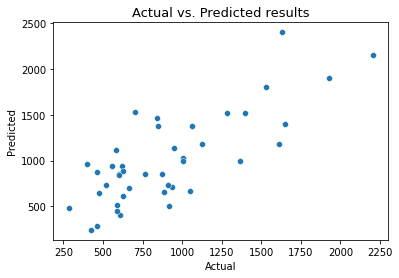

In [645]:
# Let's examine a scatterplot of the actual vs. predicted values
sns.scatterplot(data=ReturnR2value(NeighCovid,'ActualVsPred'), \
                x = 'Actual', y = 'Predicted')
plt.title("Actual vs. Predicted results", fontsize=13);

Let's look at the results of the model. The **$R^2$ value is 0.43**. It's lower than simply using one predictor.

In [646]:
print(f"The R-squared value is: \
      {ReturnR2value(NeighCovid,'R2')} \nThe Root MSE is:\t\
      {ReturnR2value(NeighCovid,'MSE')} \nThe Intercept is:\t\
      {ReturnR2value(NeighCovid,'Intercept')}")               

The R-squared value is:       43.47 
The Root MSE is:	      330.03675517892543 
The Intercept is:	      1212.2741827886584


We can try to remove outliers in each column but I suspect it won't help the accuracy of the model. We have already seen that Rate has outliers, the figure below also shows there are a couple outliers in BachelorDegree and ManufactJob.

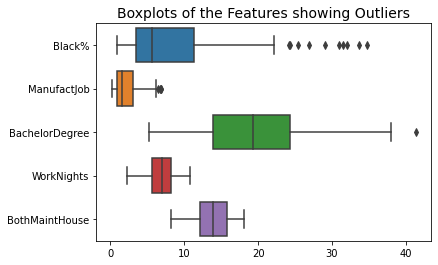

In [647]:
# Outliers
sns.boxplot(data=NeighCovid.drop('Rate',axis=1), orient="h");
plt.title("Boxplots of the Features showing Outliers",fontsize=14);

In [648]:
# Let's call the function to remove outliers
newNeighCovid = RemoveOutlierDF(NeighCovid)

In [649]:
print(f"The R-squared value is: \
      {ReturnR2value(newNeighCovid,'R2')} \nThe Root MSE is:\t\
      {ReturnR2value(newNeighCovid,'MSE')} \nThe Intercept is:\t\
      {ReturnR2value(newNeighCovid,'Intercept')}")    

The R-squared value is:       56.82 
The Root MSE is:	      432.34644674183556 
The Intercept is:	      1031.6761147565676


These are very good results as the $R^2$ value has improved to almost **57%**. This is considered very good for a social science study.

In [650]:
print(f"We removed {NeighCovid.shape[0] - newNeighCovid.shape[0]} outliers from the dataframe")

We removed 13 outliers from the dataframe


Let's look at the new Predicted vs Actual plot. It's not bad, although it seems to be less accurate for the mid level values.

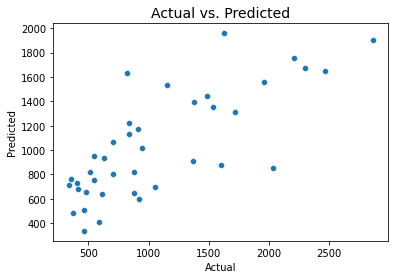

In [651]:
sns.scatterplot(data = ReturnR2value(newNeighCovid, 'ActualVsPred'),
                x='Actual', y='Predicted')
plt.title("Actual vs. Predicted", fontsize=14);

### Recursive Feature Elimination (RFE)

Let's try a technique called recursive feature elimination (RFE) and see how it compares to our current model. RFE is part of python's sklearn package.

RFE is described as follows: 

_Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features._ 

In [743]:
# Let's perform RFE on our dataset of the top 100 features. This should
# find only the necessary number of features.

# Our feat_cor contain our top 100 features
top100cols = [x for x in feat_cor.iloc[1:,:]['index']]
X = NeighCases[top100cols]
y = NeighCases['Rate per 100,000 people']

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 7)
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y);
# print(rfe.support_)
# print(rfe.ranking_);

Now let's check what the RFE recommended columns are.

In [828]:
rfe_cols = [x for x in X.columns[rfe.support_]]
dfCN0 = colNames[colNames['index'].isin(rfe_cols)]

In [830]:
#colNames[colNames['index'].isin(rfe_cols)]
#print(dfCN0[['Category','Topic','Characteristic']].to_latex(index=False)) 

This is interesting. Three have one factor that has to do| with Education, two with languages, two with income and two with immigration.

Let's check the $R^2$ when we use these columns.

In [655]:
rfe_df = NeighCases[rfe_cols].join(NeighCases['Rate per 100,000 people'])

In [656]:
ReturnR2value(rfe_df)

44.81

The $R^2$ value of this model is almost **45%**. That's pretty good.

The following table shows the correlation between columns. A couple features are **highly correlated** so lets remove those, and remove outliers and try again.

In [657]:
#rfe_df.corr()
#print(rfe_df.corr().to_latex(index=False)) 

In [658]:
# Remove column 964 and 330
rfe_df.drop(["Col_964","Col_330"], axis=1, inplace=True)

In [659]:
# Remove outliers
NewRfeDf = RemoveOutlierDF(rfe_df)

In [660]:
print(f"{rfe_df.shape[0] - NewRfeDf.shape[0]} columns with outliers were removed.")

28 columns with outliers were removed.


In [661]:
ReturnR2value(NewRfeDf)

2.93

The $R^2$ has now dropped significantly to 2.93.

### P-value for Feature Reduction

One way to select predictor variables is using the p-value. 

P-value gives us the probability of finding an observation assuming that a particular hypothesis is true. It's this probability that we use to decide whether to reject $H_o$, the Null hypothesis.
We can use this to determine which features we can remove from the dataset. 

As we remove features this effects the p-values for each feature in the dataset. One by one we will remove a feature with a high value (non significant $p>0.5$) and recalculate the p-values.

The following table shows the p-values for each predictor.

In [662]:
X = newNeighCovid[['Black%', 'ManufactJob', 'BachelorDegree', 'WorkNights', 'BothMaintHouse']]
y = newNeighCovid['Rate']

In [663]:
import statsmodels.api as sm
OLS_regressor = sm.OLS(y,X)
results_summary = OLS_regressor.fit().summary()
dfRs = pd.DataFrame(results_summary.tables[1])
#print(dfRs.to_latex(index=False)) 

The p-values indicate that there are potentially two features that do not contribute to the model.
Let's remove one at a time and check the results. Here's the values after one predictor is removed.

In [664]:
X = newNeighCovid[['Black%', 'ManufactJob', 'WorkNights', 'BothMaintHouse']]
y = newNeighCovid['Rate']
import statsmodels.api as sm
OLS_regressor = sm.OLS(y,X)
results_summary2 = OLS_regressor.fit().summary()
dfRs2 = pd.DataFrame(results_summary2.tables[1])
#print(dfRs2.to_latex(index=False)) 

Now there's only one feature left with a high p-value, let's remove it. Now we check the p-values and see that there are no insignificant values.

In [665]:
X = newNeighCovid[['Black%', 'ManufactJob', 'WorkNights']]
y = newNeighCovid['Rate']
import statsmodels.api as sm
OLS_regressor = sm.OLS(y,X)
results_summary3 = OLS_regressor.fit().summary()
dfRs3 = pd.DataFrame(results_summary3.tables[1])
#print(dfRs3.to_latex(index=False))

Now all our features are significant. Let's check the $R^2$ value and the MSE of the new model.

In [745]:
newestNeighCovid = newNeighCovid[['Black%', 'ManufactJob', 'WorkNights', 'Rate']]

print(f"The R-squared value is: \
      {ReturnR2value(newestNeighCovid,'R2')} \nThe Root MSE is:\t\
      {ReturnR2value(newestNeighCovid,'MSE')} \nThe Intercept is:\t\
      {ReturnR2value(newestNeighCovid,'Intercept')}")    

The R-squared value is:       60.52 
The Root MSE is:	      413.42407505558594 
The Intercept is:	      1038.1824194302878


The new coefficients are:

In [832]:
#print(ReturnR2value(newestNeighCovid, 'Coefficients').to_latex(index=True))

Great news, we have simplified the model and increased the $R^2$ value, in terms of a percent, to **over 60%**. 

This could be considered a very good $R^2$ value for a social sciences type of study as this one.$^{[6]}$

Our final model is:

_Rate = 1038 + 157.7 \* Black% + 140.8 \* ManufactJob + 170.1 \* WorkNights_

# Discussion

This study used multiple linear regression to predict covid rates in Toronto's 140 neighborhoods using demographic data from Stats Canada. The data initially contained over 2,300 potential predictors. The correlation of these features to the target variable were analyzed in order to limit the number of potential predictors. Features which were highly correlated to each other were removed and an analysis of the p-values were done recursively to eliminate further predictors. Using the IQR method a few neighborhoods were removed that were considered outliers. The final model used only three variables to predict covid rates in the neighborhoods with an $R^2$ value of 0.605.

Specifically these variables in the Stats Canada demographic database are know as 
*Black (Visible Minority)*, *Occupations in manufacturing and utilities*, 
and *Journey to work Between 12 p.m. and 4:59 a.m.*. It has been suggested that certain racialized communities are affected by covid for various reasons including a higher proportion with underlying health conditions such as hypertension, the increased likelihood of living in more densely populated neighborhoods, and the lower proportion that can work from home.$^{[3]}$

Further research is warranted and could include a larger analysis of neighborhoods across Canada, or in other countries. A linear model was appropriate for this analysis, as the predictors used were not highly correlated to each other, they had a linear relationship with the target variable, and they were all fairly normally distributed. A model such as the one built for this study could help to target resources where they are most needed, or to preemptively determine where the most severe outbreaks will occur in order to take preventative action. 

# References

# Appendix

I noticed that the graph of Bachelor Degree vs. Rate appears to follow a 2nd degree polynomial. Linear regression assumes the relationship between the dependent and independent variables are linear, but sometimes the relationship is more complex. We need to generate a higher level equation. In this case the equation would be: 

$Y = \beta_0 + \beta_1x + \beta_2x^2$

This is still a linear model however we are now fitting a **quadratic** equation.

We must now use the PolynomialFeatures class provided by sklearn. We then train the model using Linear Regression.

Let's check what the $R^2$ value would be if we just assume a linear relationship. It's **-22.51** which is not that good. It shows a moderately weak negative relationship between the independent and dependent variables.

In [934]:
ReturnR2value(NeighCovid[['BachelorDegree','Rate']])

-22.51

Now let's fit the pattern to a 2nd degree polynomial and check the $R^2$ value again.

In [935]:
import operator

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

dfPoly = NeighCovid[['BachelorDegree','Rate']]
#dfPoly = RemoveOutlierDF(dfPoly)

X = dfPoly[['BachelorDegree']]
y = dfPoly['Rate']

polynomial_features = PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(X)

model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)

rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y, y_poly_pred)
print(rmse)
print(r2)

498.5250780689128
0.5437237661821185


We can see that the $R^2$ value as a percent is now **54.4**. That is a large improvement.

Let's visualize this relationship with a best fitting line.

Text(0.5, 0, 'Percent with Bachelor Degrees')

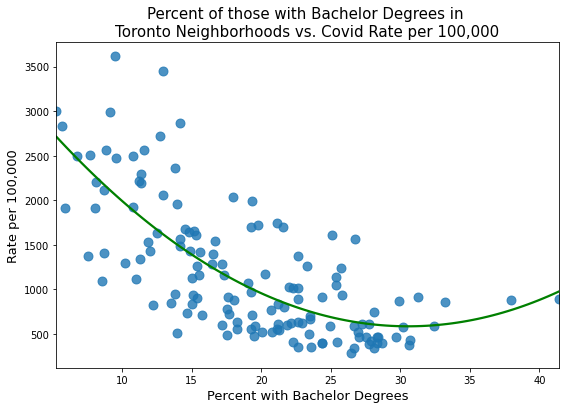

In [936]:
plt.figure(figsize=(9, 6))
ax = sns.regplot(x="BachelorDegree", y="Rate", data=dfPoly,
                 scatter_kws={"s": 80}, line_kws={"color": "green"},
                 order=2, ci=None)

plt.title("Percent of those with Bachelor Degrees in \n\
Toronto Neighborhoods vs. Covid Rate per 100,000", fontsize = 15)
#plt.suptitle("with best fitting 2-degree polynomial line")
plt.ylabel("Rate per 100,000", fontsize=13)
plt.xlabel("Percent with Bachelor Degrees", fontsize=13)